# 0. Fake News Labeler

This notebook contains code to label the FNC-Core dataset with a team of pre-trained experts.

## Dataset

The FNC (Fake-News-Covid) dataset is a twitter-sampled stream of tweets for fake news detection.It is collected along with its social context of usernames, account details, retweets, likes, quote tweets, among other features.

FNC has several components:

- **FNC-Raw**: The raw stream collected from the Twitter Sampled Stream
- **FNC-Filtered**: The filtered stream obtained from the Twitter Sampled Stream with covid-related keyword filters.
- **FNC-Neighbors**: Samples from FNC-Raw that were not filtered into FNC-Filtered due to missing, censored, or mispelled keywords, but are semantically similar to FNC-Filtered. We detect these with embedding extensions.
- **FNC-Extended**: FNC-Filtered combined with FNC-Neighbors to yield a more complete filtered dataset. We can refer to monthly subsets as FNC-Extended-\<MonthYear\>, e.g. FNC-Extended-Jan2020

These are the unlabeled parts of FNC. With this notebook, we can label a subset of FNC-Extended with high accuracy. These also fall under several components:

- **FNC-Extended-Oracle**: Samples from FNC-Extended that are labeled with human annotators. FNC-Extended-Oracle has 10k samples. Since FNC-Extended spans 25 months, we have 400 labeled samples per month.
- **FNC-Expert-\<Expert\>-\<MonthYear\>**: The FNC-Extended-\<MonthYear\> subset is labeled by an expert with name \<Expert\>.
- **FNC-Labeled**: We integrate labels from several experts to generate the final labeled set. We can evaluate labeling accuracy on the intersection with FNC-Extended-Oracle. Monthly subsets are FNC-Labeled-\<MonthYear\>

## This Notebook
In this notebook, we will:

- Generate FNC-Filtered (unless the raw data is already of this format...should recheck)
- Possibly generate FNC-Neighbors (unless raw data is already of this format...should recheck)
- Generate FNC-Expert. For this, we have a list of experts already generated. We will use EdnaML Deployments to load an expert, then load our data from Azure, then label each point, and save the generated label. If a model abstains for some point, we will score that as a [-1]. True News is [1]. Fake News is [0]. Then, the labels will be saved to this instance. We will download the labels, labeled as FNC-Expert-[ExpertName]-[MonthYear]. For each file, we will also save any necessary label characteristics in the same line, i.e.: [label,L-score, model-l-score-threshold, etc]
- Possibly Generate FNC-Labeled. Once we have several expert labeled sets, we will integrate them together using Snorkel, EEWS, etc... Snorkel is easy to implement. We might skip EEWS and ATEAM.

In [ ]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.0 MB/s eta 0:00:00


# 1. Setup -- Gdrive Connect, Git clone, Model  Downloads

## Connect to Google Drive

In [ ]:
!nvidia-smi

Sun Aug 20 01:47:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os.path as osp
import os, glob, shutil

In [ ]:
# Set Gogle Drive Connection
#if not osp.exists("./drive"):
from google.colab import drive

#https://stackoverflow.com/questions/69822304/google-colab-google-drive-can%c2%b4t-be-mounted-anymore-browser-popup-google-dri
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Git Clone

### From Source

In [ ]:
! rm -rf -- EdnaML

In [ ]:
! git clone -b master https://github.com/asuprem/EdnaML
!python -V

Cloning into 'EdnaML'...
remote: Enumerating objects: 9559, done.
remote: Counting objects: 100% (1462/1462), done.
remote: Compressing objects: 100% (481/481), done.
remote: Total 9559 (delta 901), reused 1385 (delta 833), pack-reused 8097
Receiving objects: 100% (9559/9559), 3.32 MiB | 5.42 MiB/s, done.
Resolving deltas: 100% (6295/6295), done.
Python 3.10.12


In [ ]:
!pip install setuptools==61.2.0
!pip install -e EdnaML/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.2 requires setuptools>65.5.1, but you have setuptools 61.2.0 which is incompatible.


Obtaining file:///content/EdnaML
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.3 MB/s eta 0:00:00
  Running setup.py develop for ednaml


###  From PyPi

In [ ]:
#! python -V

In [ ]:
#! pip3 install --pre ednaml==0.1.4

## AlBERT / ModelFile Data Download

(And assume they are FNC-Extended-MonthYear)

In [ ]:
!ls ./drive/MyDrive/

In [ ]:
# Commented in for Sp 23
!cp ./drive/MyDrive/Datasets/PreTrained/Albertv2/30k* .
!cp ./drive/MyDrive/Datasets/PreTrained/Albertv2/pytorch_model.bin .

# Restart Runtime Here!!!!

# 2. Raw Data

In [ ]:
tweet_file = "tweets-2020-01-22"
proxy = 40

# 3. Generating FNC-Filtered from FNC-Raw

Here, we will use an EdnaML workflow to generate FNC-Filtered from FNC-Raw. This is not really a learnable model, rather a simple keyword matcher.

Essentially, we will build a workflow where we:\

1. Crawl an FNC Source and download if it does not exist
2. Create datashards from the Source, with only testing data since there is no "training" to be performed
3. Deploy a ModelAbstract model that reads a batch of raw text data, and checks whether elements of this batch contain our keywords. If they do, we label 1. If they do not, we label 0.
4. The Deployment thus generates 2 outputs: a file containing fnc-filtered, and a file fnc-nonfiltered

In [ ]:
# cleanup
!rm -rf -- test-datashard-artifacts

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import ednaml
import glob, os
from ednaml.core import EdnaDeploy, EdnaML
torch.__version__

'2.0.1+cu118'

In [ ]:
config = "./EdnaML/profiles/FNC/filtered/config.yml"
crawler_generator = "./EdnaML/profiles/FNC/fnc-crawler.py"
filter_model_deployment = "./EdnaML/profiles/FNC/fnc-filtered.py"

In [ ]:
ed = EdnaDeploy(config=config)
ed.cfg.DEPLOYMENT.OUTPUT_ARGS["basename"] = "%s"%tweet_file
ed.cfg.DEPLOYMENT.DATAREADER.CRAWLER_ARGS["azfile"] = "%s.json.gz"%tweet_file

In [ ]:
ed.add(crawler_generator)
ed.add(filter_model_deployment)
ed.apply()

23:38:07 Adding a crawler, from /content/EdnaML/profiles/FNC/fnc-crawler.py, with inferred name FNCCrawler
23:38:07 Adding a generator, from /content/EdnaML/profiles/FNC/fnc-crawler.py, with inferred name FNCRawGenerator
23:38:07 Adding a model, from /content/EdnaML/profiles/FNC/fnc-filtered.py, with inferred name FNCFilter
23:38:07 Adding a deployment, from /content/EdnaML/profiles/FNC/fnc-filtered.py, with inferred name FNCFilterDeployment
23:38:07 ****************************************
23:38:07 
23:38:07 
23:38:07 Using the following configuration:
23:38:07 DEPLOYMENT:
  DATAREADER:
    CRAWLER_ARGS:
      azcontainer: edna-covid-raw
      azfile: tweets-2020-01-22.json.gz
      azstorage: ednadatasets
    DATAREADER: AlbertReader
    DATASET_ARGS:
      classificationclass:
      - fnews
      shard_replace: false
      shardname: fnc-raw-shard
      shardpath: datashard-artifacts
      shardsize: 20000
      shuffle: false
    GENERATOR: null
    GENERATOR_ARGS: {}
  DEPLOY: Bas

Registering a crawler: <class './EdnaML/profiles/FNC/fnc-crawler.py.FNCCrawler'>, from file: /content/EdnaML/profiles/FNC/fnc-crawler.py
Registering a generator: <class './EdnaML/profiles/FNC/fnc-crawler.py.FNCRawGenerator'>, from file: /content/EdnaML/profiles/FNC/fnc-crawler.py
Registering a model: <class './EdnaML/profiles/FNC/fnc-filtered.py.FNCFilter'>, from file: /content/EdnaML/profiles/FNC/fnc-filtered.py
Registering a deployment: <class './EdnaML/profiles/FNC/fnc-filtered.py.FNCFilterDeployment'>, from file: /content/EdnaML/profiles/FNC/fnc-filtered.py
5637377/5637377 bytes [████████████████████████████████████████████████████████████████████████████████████████████████████]
Download of tweets-2020-01-22.json.gz to https://ednadatasets.blob.core.windows.net/edna-covid-raw/tweets-2020-01-22.json.gz completed


23:38:11 Generating dataloader `FNCRawGenerator` with `test` mode
23:38:16 Generated test data/query generator
23:38:16 Loaded ednaml_model_builder from ednaml.models to build model
23:38:16 Finished instantiating model with FNCFilter architecture
23:38:16 Adding plugins after constructing model
23:38:16 No saved model weights provided. Inferring weights path.
23:38:16 No previous stop exists. Not loading weights.
23:38:16 Model Summary retured the following error:
23:38:16 Traceback (most recent call last):
  File "/content/EdnaML/src/ednaml/core/EdnaML.py", line 888, in getModelSummary
    self.cfg.TRAIN_TRANSFORMATION.INPUT_SIZE,
AttributeError: 'TransformationConfig' object has no attribute 'INPUT_SIZE'

23:38:16 1 GPUs available


NOT saving metadata. saveMetadata() function not set up.


In [ ]:
ed.deploy()

23:38:16 Starting deployment
23:38:16 Logging to:	fnc-filter-v1-offshelf-raw-logger.log
23:38:16 Setting up plugin hooks. Plugins will fire during:  always
23:38:16 Executing deployment for  1 epochs
23:38:16 Starting epoch 0
23:38:17 Executing end of epoch steps
23:38:17 Completed deployment task.


## Cleanup

In [ ]:
import os
if os.path.exists(tweet_file+".json"):
  os.remove(tweet_file+".json")
if os.path.exists(tweet_file+".json.gz"):
  os.remove(tweet_file+".json.gz")
! rm test-datashard-artifacts/fnc-raw*
! rm train-datashard-artifacts/fnc-raw*
! rm test-datashard-artifacts/len.txt

rm: cannot remove 'train-datashard-artifacts/fnc-raw*': No such file or directory


In [ ]:
! wc -l $tweet_file-filtered.json

17718 tweets-2020-01-22-filtered.json


In [ ]:
! wc -l $tweet_file-unfiltered.json

6333 tweets-2020-01-22-unfiltered.json


## Filtered subset scaling (for class)

In [ ]:
filter_scale = 1    # Notes: NA
unfilter_scale = 1  # Notes: NA

### Scaling

In [ ]:
import os
tf_filtered = tweet_file + "-filtered.json"
tf_unfiltered = tweet_file + "-unfiltered.json"
# Set reduction scale
import random
random.seed(34598344)
# Reduce filtered.json
filt_obj = open(tf_filtered, "r")
filtout_obj = open(tf_filtered + "2", "w")
for row in filt_obj:
    if random.random() <= filter_scale:
      filtout_obj.write(row)
filtout_obj.close()
filt_obj.close()
# Reduce unfiltered.json
unfilt_obj = open(tf_unfiltered, "r")
unfiltout_obj = open(tf_unfiltered + "2", "w")
for row in unfilt_obj:
    if random.random() <= unfilter_scale:
      unfiltout_obj.write(row)
unfiltout_obj.close()
unfilt_obj.close()
# Delete old files
os.remove(tf_filtered)
os.remove(tf_unfiltered)
# Rename to old file name
os.rename(tf_filtered+"2", tf_filtered)
os.rename(tf_unfiltered+"2", tf_unfiltered)

In [ ]:
! wc -l $tweet_file-filtered.json

17718 tweets-2020-01-22-filtered.json


In [ ]:
! wc -l $tweet_file-unfiltered.json

6333 tweets-2020-01-22-unfiltered.json


# 4. Generating FNC-Neighbors from FNC-Filtered and FNC

Here, we will take the json files generated from FNC-Filter: `filter.json` and `unfilter.json`.

The filter.json content is used to fine-tune a BERT model. This BERT model implements keyword masking, that is, specific keywords are masked

Then we use a cluster_estimator plugin to estimate the best number of clusters with KMeans for the training dataset.

Then, we insert a high-density estimator plugin with the best number of clusters as proxies

Then, we will use a Deployment to iterate through unfilter. For each, we will generate the features, and use the high-density estimator plugin to check if it exists in the high density set of existing clusters. Note that the unfilter data implements the same masking as the training model. Any samples that exist are placed in `extended.json`

## 4.1 Finetuning MLM with keyword masking

In [ ]:
# Cleanup ONLY if starting from scratch, not if already doing 4.1
# Also cleanup if switching datasets
!rm test-datashard-artifacts/fnc-filtermask*
!rm train-datashard-artifacts/fnc-filtermask*

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import ednaml
import glob, os
from ednaml.core import EdnaDeploy, EdnaML
torch.__version__

'2.0.1+cu118'

In [ ]:
config = "./EdnaML/profiles/FNC/extension/config.yml"
crawler = "./EdnaML/profiles/FNC/fnc-crawler.py"
filtermask_generator = "./EdnaML/profiles/FNC/fnc-filtermasked.py"
extension_model = "./EdnaML/profiles/FNC/fnc-extension.py"

In [ ]:
eml = EdnaML(config=config, config_inject=[("SAVE.MODEL_QUALIFIER", tweet_file), ("SAVE.MODEL_VERSION", 1), ("SAVE.STEP_SAVE_FREQUENCY", 50000), ("EXECUTION.EPOCHS", 1)])
#eml = EdnaML(config=config, config_inject=[("SAVE.MODEL_QUALIFIER", tweet_file)])
eml.cfg.EXECUTION.DATAREADER.CRAWLER_ARGS["train_file"] = "%s-filtered.json"%tweet_file
eml.cfg.EXECUTION.DATAREADER.CRAWLER_ARGS["test_file"] = "%s-unfiltered.json"%tweet_file

Injected key-value pair:  SAVE.MODEL_QUALIFIER, tweets-2020-01-22
Injected key-value pair:  SAVE.MODEL_VERSION, 1
Injected key-value pair:  SAVE.STEP_SAVE_FREQUENCY, 50000
Injected key-value pair:  EXECUTION.EPOCHS, 1
Log file exists at fnc-extension-v1-albert-tweets-2020-01-22/fnc-extension-v1-albert-tweets-2020-01-22-logger.log. Will attempt to append there.


In [ ]:
eml.add(crawler)
eml.add(filtermask_generator)
eml.add(extension_model)
eml.apply()

23:57:46 Adding a crawler, from /content/EdnaML/profiles/FNC/fnc-crawler.py, with inferred name FNCCrawler
23:57:46 Adding a generator, from /content/EdnaML/profiles/FNC/fnc-crawler.py, with inferred name FNCRawGenerator
23:57:46 Adding a generator, from /content/EdnaML/profiles/FNC/fnc-filtermasked.py, with inferred name FNCFilterMaskGenerator
23:57:46 Adding a model, from /content/EdnaML/profiles/FNC/fnc-extension.py, with inferred name FNCAlbertModeler
23:57:46 Adding a trainer, from /content/EdnaML/profiles/FNC/fnc-extension.py, with inferred name FNCAlbertModelerTrainer
23:57:46 ****************************************
23:57:46 
23:57:46 
23:57:46 Using the following configuration:
23:57:46 DEPLOYMENT:
  DATAREADER:
    CRAWLER_ARGS: {}
    DATAREADER: DataReader
    DATASET_ARGS: {}
    GENERATOR: null
    GENERATOR_ARGS: {}
  DEPLOY: BaseDeploy
  DEPLOYMENT_ARGS: {}
  EPOCHS: 1
  OUTPUT_ARGS: {}
  PLUGIN:
    HOOKS: always
    RESET: false
EXECUTION:
  DATAREADER:
    CRAWLER_AR

Registering a crawler: <class './EdnaML/profiles/FNC/fnc-crawler.py.FNCCrawler'>, from file: /content/EdnaML/profiles/FNC/fnc-crawler.py
Registering a generator: <class './EdnaML/profiles/FNC/fnc-crawler.py.FNCRawGenerator'>, from file: /content/EdnaML/profiles/FNC/fnc-crawler.py
Registering a generator: <class './EdnaML/profiles/FNC/fnc-filtermasked.py.FNCFilterMaskGenerator'>, from file: /content/EdnaML/profiles/FNC/fnc-filtermasked.py
Registering a model: <class './EdnaML/profiles/FNC/fnc-extension.py.FNCAlbertModeler'>, from file: /content/EdnaML/profiles/FNC/fnc-extension.py
Registering a trainer: <class './EdnaML/profiles/FNC/fnc-extension.py.FNCAlbertModelerTrainer'>, from file: /content/EdnaML/profiles/FNC/fnc-extension.py
Registering a deployment: <class './EdnaML/profiles/FNC/fnc-extension.py.FNCTrainingFeaturesDeploy'>, from file: /content/EdnaML/profiles/FNC/fnc-extension.py


23:57:47 Building Dataset
23:57:47 Generating shards
100%|██████████| 1/1 [00:24<00:00, 24.89s/it]
23:58:12 Building Dataloader
23:58:12 Generated training data generator with 17718 training data points
23:58:12 Running classification model with classes: {'fnews': {'classes': 2}}
23:58:12 Building Transforms
23:58:13 Building Dataset
23:58:13 Generating shards
100%|██████████| 1/1 [00:05<00:00,  5.43s/it]
23:58:19 Building Dataloader
23:58:19 Generated test data/query generator
23:58:19 Loaded ednaml_model_builder from ednaml.models to build model


loading weights file pytorch_model.bin


23:58:19 Finished instantiating model with FNCAlbertModeler architecture
23:58:19 Adding plugins after constructing model
23:58:19 No saved model weights provided.
23:58:19 Model Summary retured the following error:
23:58:19 Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py", line 295, in forward_pass
    _ = model(*x, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1538, in _call_impl
    result = forward_call(*args, **kwargs)
  File "/content/EdnaML/src/ednaml/models/ModelAbstract.py", line 140, in forward
    feature_logits, features, secondary_outputs = self.forward_impl(
  File "/content/./EdnaML/profiles/FNC/fnc-extension.py", line 105, in forward_impl
    outputs = self.encoder(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1538, in _call_impl
    result = forward_call(*args, **kwargs)
  File "/content/EdnaML/src/ednaml/models/Albert.py", line 7

Errors 
	 {'missing_keys': [], 'unexpected_keys': [], 'error_msgs': []}
INPUT SIZE ====  [16, 512]
NOT saving metadata. saveMetadata() function not set up.


In [ ]:
eml.train()

23:58:25 Starting training
23:58:25 Logging to:	fnc-extension-v1-albert-tweets-2020-01-22-logger.log
23:58:25 Models will be saved to local directory:	fnc-extension-v1-albert-tweets-2020-01-22
23:58:25 Models will be backed up to drive directory:	./drive/MyDrive/Projects/FNC/Models/fnc-extension-v1-albert-tweets-2020-01-22
23:58:25 Models will be saved with base name:	fnc-extension-v1_epoch[].pth
23:58:25 Optimizers will be saved with base name:	fnc-extension-v1_epoch[]_optimizer.pth
23:58:25 Schedulers will be saved with base name:	fnc-extension-v1_epoch[]_scheduler.pth
23:58:25 Resuming training from epoch 3. Loading saved state from 2
23:58:25 Loading model, optimizer, and scheduler from drive backup.
23:58:25 Loading model, optimizer, and scheduler from drive backup.
23:58:25 Finished loading model state_dict from ./drive/MyDrive/Projects/FNC/Models/fnc-extension-v1-albert-tweets-2020-01-22/fnc-extension-v1_epoch2_step0.pth
23:58:25 Finished loading optimizer state_dict from ./driv

In [ ]:
eml.trainer.save()

23:59:25 Saving model, optimizer, and scheduler.
23:59:26 Performing drive backup of model, optimizer, and scheduler.


In [ ]:
eml.eval()

00:00:11 		Reconstruction	Domain 0: 0.157
00:00:11 	Masked Prediction	Domain 0: 0.157
00:00:11 	Unmasked Prediction	Domain 0: 0.000


(None, None, {'fnews': 2}, None)

## 4.1.1. Deployment to generate training features
Now we will use our trained LLM to generate the training features again.

These features will be used to determine the best number of clusters and other hyperparameters. Subsequently, we can use our calculated hyperparameters to build a K-Means Clustering Plugin that includes a High-Density Set estimator.

In [ ]:
! rm *.h5*
! rm train-datashard-artifacts/*

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import ednaml
import glob, os
from ednaml.core import EdnaDeploy, EdnaML
torch.__version__

'2.0.1+cu118'

In [ ]:
config = "./EdnaML/profiles/FNC/extension/config.yml"
deploy = "./EdnaML/profiles/FNC/extension/training_features.yml"  # remove masking in data generation process
crawler = "./EdnaML/profiles/FNC/fnc-crawler.py"
filtermask_generator = "./EdnaML/profiles/FNC/fnc-filtermasked.py"
extension_model = "./EdnaML/profiles/FNC/fnc-extension.py"

In [ ]:
ed = EdnaDeploy(config=config, deploy = deploy, dataloader_mode = "train", config_inject=[("SAVE.MODEL_QUALIFIER", tweet_file)])
ed.cfg.DEPLOYMENT.OUTPUT_ARGS["feature_file"] = "%s-filtered-features"%tweet_file
ed.cfg.DEPLOYMENT.DATAREADER.CRAWLER_ARGS["train_file"] = "%s-filtered.json"%tweet_file

Injected key-value pair:  SAVE.MODEL_QUALIFIER, tweets-2020-01-22
Log file exists at fnc-extension-v1-albert-tweets-2020-01-22/fnc-extension-v1-albert-tweets-2020-01-22-logger.log. Will attempt to append there.


In [ ]:
ed.add(crawler)
ed.add(filtermask_generator)
ed.add(extension_model)  # With model AND deployment defined
ed.apply()

00:19:14 Adding a crawler, from /content/EdnaML/profiles/FNC/fnc-crawler.py, with inferred name FNCCrawler
00:19:14 Adding a generator, from /content/EdnaML/profiles/FNC/fnc-crawler.py, with inferred name FNCRawGenerator
00:19:14 Adding a generator, from /content/EdnaML/profiles/FNC/fnc-filtermasked.py, with inferred name FNCFilterMaskGenerator
00:19:14 Adding a model, from /content/EdnaML/profiles/FNC/fnc-extension.py, with inferred name FNCAlbertModeler
/content/EdnaML/src/ednaml/core/EdnaML.py:941: UserWarning: keyvalue trainer in REGISTERED_EDNA_COMPONENTS <class './EdnaML/profiles/FNC/fnc-extension.py.FNCAlbertModelerTrainer'> is not available in self.decorator_reference. Not adding.
  warnings.warn(
00:19:14 Adding a deployment, from /content/EdnaML/profiles/FNC/fnc-extension.py, with inferred name FNCTrainingFeaturesDeploy
00:19:14 ****************************************
00:19:14 
00:19:14 
00:19:14 Using the following configuration:
00:19:14 DEPLOYMENT:
  DATAREADER:
    CRAWL

Registering a crawler: <class './EdnaML/profiles/FNC/fnc-crawler.py.FNCCrawler'>, from file: /content/EdnaML/profiles/FNC/fnc-crawler.py
Registering a generator: <class './EdnaML/profiles/FNC/fnc-crawler.py.FNCRawGenerator'>, from file: /content/EdnaML/profiles/FNC/fnc-crawler.py
Registering a generator: <class './EdnaML/profiles/FNC/fnc-filtermasked.py.FNCFilterMaskGenerator'>, from file: /content/EdnaML/profiles/FNC/fnc-filtermasked.py
Registering a model: <class './EdnaML/profiles/FNC/fnc-extension.py.FNCAlbertModeler'>, from file: /content/EdnaML/profiles/FNC/fnc-extension.py
Registering a trainer: <class './EdnaML/profiles/FNC/fnc-extension.py.FNCAlbertModelerTrainer'>, from file: /content/EdnaML/profiles/FNC/fnc-extension.py
Registering a deployment: <class './EdnaML/profiles/FNC/fnc-extension.py.FNCTrainingFeaturesDeploy'>, from file: /content/EdnaML/profiles/FNC/fnc-extension.py


00:19:14 Generating dataloader `FNCFilterMaskGenerator` with `train` mode
00:19:14 Building Transforms
00:19:17 Building Dataset
00:19:17 Generating shards
100%|██████████| 1/1 [00:14<00:00, 14.55s/it]
00:19:31 Building Dataloader
00:19:31 Generated test data/query generator
00:19:31 Loaded ednaml_model_builder from ednaml.models to build model


loading weights file pytorch_model.bin


00:19:32 Finished instantiating model with FNCAlbertModeler architecture
00:19:32 Adding plugins after constructing model
00:19:32 No saved model weights provided. Inferring weights path.
00:19:32 Loading model from drive backup.
00:19:32 Using weights from last saved epoch 2, at path None.


Errors 
	 {'missing_keys': [], 'unexpected_keys': [], 'error_msgs': []}


00:19:34 Model Summary retured the following error:
00:19:34 Traceback (most recent call last):
  File "/content/EdnaML/src/ednaml/core/EdnaML.py", line 888, in getModelSummary
    self.cfg.TRAIN_TRANSFORMATION.INPUT_SIZE,
AttributeError: 'TransformationConfig' object has no attribute 'INPUT_SIZE'

00:19:34 1 GPUs available


NOT saving metadata. saveMetadata() function not set up.


In [ ]:
ed.deployment.edna_context.MODEL_HAS_LOADED_WEIGHTS

False

In [ ]:
ed.deploy()

00:19:39 Starting deployment
00:19:39 Logging to:	fnc-extension-v1-albert-tweets-2020-01-22-logger.log
00:19:39 Loading a model from saved epoch 2, step 0
00:19:39 Loading model from drive backup.
00:19:39 Finished loading model state_dict from ./drive/MyDrive/Projects/FNC/Models/fnc-extension-v1-albert-tweets-2020-01-22/fnc-extension-v1_epoch2_step0.pth
00:19:39 Looking for model plugins from drive backup.
00:19:39 No plugin exists for name FastKMP-l2
00:19:39 Loaded plugins from ./drive/MyDrive/Projects/FNC/Models/fnc-extension-v1-albert-tweets-2020-01-22/fnc-extension-v1_plugins.pth
00:19:39 Setting up plugin hooks. Plugins will fire during:  always
00:19:39 Executing deployment for  1 epochs
00:19:39 Starting epoch 0
00:21:11 Performing save at epoch 1
00:21:11 Saving model plugins.
00:21:11 No plugins to save
00:21:11 Executing end of epoch steps
00:21:11 Completed deployment task.


In [ ]:
ed.saveMetadata.MODEL_SAVE_FOLDER

'fnc-extension-v1-albert-tweets-2020-01-22'

## 4.2 Estimating best number of clusters from the BERT features

In [ ]:
def cluster_sweep(features_file, batch_size, max_iters, cluster_range):
  import h5py, time
  from sklearn.cluster import MiniBatchKMeans
  inertia = []
  data = h5py.File(features_file, 'r')
  data_size = data['features'].shape[0]

  for k in cluster_range:
    print("Starting sweep for k={kval}, with {iters} iterations".format(kval=k, iters=max_iters))
    kmeans = MiniBatchKMeans(n_clusters = k, random_state = 23465356, batch_size = batch_size)
    stime = time.time()
    for iters in range(max_iters):
      for i in range(0, data_size, batch_size):
          current_data = data['features'][i:i+batch_size]
          kmeans.partial_fit(current_data)
      if iters%5 == 0:
        etime = round(time.time() - stime, 2)
        print("\t[{elapse} s] -- Completed {iters} iterations".format(iters=iters, elapse = etime))
        stime = time.time()
    print("\tCompeted MBKM for k={kval}, with inertia: {inertia}".format(kval=k, inertia = kmeans.inertia_))
    inertia.append(kmeans.inertia_)
  return inertia

In [ ]:
cluster_range = [10,20,50,100]
inertia = cluster_sweep(
    features_file = "%s-filtered-features.h5"%tweet_file,
    batch_size=256,
    max_iters = 25,
    cluster_range = cluster_range
)

Starting sweep for k=10, with 25 iterations


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


	[0.95 s] -- Completed 0 iterations
	[4.02 s] -- Completed 5 iterations
	[3.02 s] -- Completed 10 iterations
	[2.69 s] -- Completed 15 iterations
	[2.72 s] -- Completed 20 iterations
	Competed MBKM for k=10, with inertia: 14.719842910766602
Starting sweep for k=20, with 25 iterations


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


	[0.78 s] -- Completed 0 iterations
	[3.94 s] -- Completed 5 iterations
	[3.18 s] -- Completed 10 iterations
	[2.72 s] -- Completed 15 iterations
	[2.71 s] -- Completed 20 iterations
	Competed MBKM for k=20, with inertia: 10.361695289611816
Starting sweep for k=50, with 25 iterations


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


	[0.66 s] -- Completed 0 iterations
	[4.1 s] -- Completed 5 iterations
	[3.36 s] -- Completed 10 iterations
	[2.85 s] -- Completed 15 iterations
	[2.83 s] -- Completed 20 iterations
	Competed MBKM for k=50, with inertia: 7.377807140350342
Starting sweep for k=100, with 25 iterations


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


	[0.91 s] -- Completed 0 iterations
	[4.46 s] -- Completed 5 iterations
	[3.41 s] -- Completed 10 iterations
	[3.0 s] -- Completed 15 iterations
	[2.98 s] -- Completed 20 iterations
	Competed MBKM for k=100, with inertia: 5.764917373657227


In [ ]:
# In case of interruptions or crashes...
#inertia2 = [1660, 5510, 3100, 2290] + inertia

<ipython-input-17-1a0de2428c2d>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x="cluster_range", y="inertia", data=pd.DataFrame(list(zip(inertia, cluster_range)), columns=["inertia", "cluster_range"]),


[Text(0.5, 1.0, 'Elbow Plot for KMeans')]

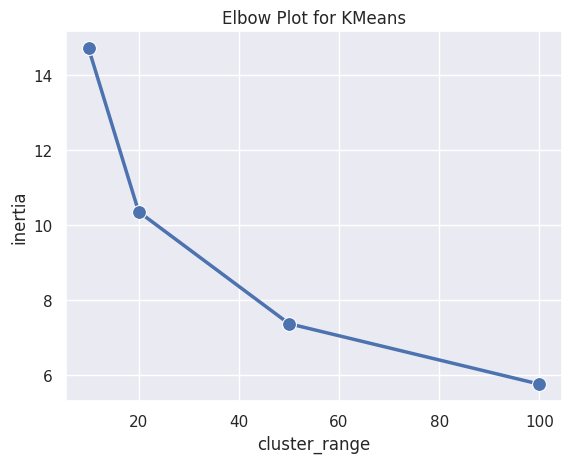

In [ ]:
import seaborn as sns
import pandas as pd
sns.set_theme(style="darkgrid")
sns.lineplot(x="cluster_range", y="inertia", data=pd.DataFrame(list(zip(inertia, cluster_range)), columns=["inertia", "cluster_range"]),
             palette="tab10", linewidth=2.5, marker="o", markersize=10). \
              set(title="Elbow Plot for KMeans")

So, we find here that for FNC Jan 2020 that **40 PROXIES** fits the elbow visual test.

In [ ]:
proxy = 40

## 4.3 Generate Plugins

Using k=20 proxies, we will now generate the FastKMeans Plugin for our LLM for this FNC window.

In [ ]:
!rm -rf -- train-datashard-artifacts/

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import ednaml
import glob, os
from ednaml.core import EdnaDeploy, EdnaML
torch.__version__

'2.0.1+cu118'

In [ ]:
config = "./EdnaML/profiles/FNC/extension/config.yml"
deploy = "./EdnaML/profiles/FNC/extension/fastkmeans.yml" #basically, set up plugin info, and remove masking
crawler = "./EdnaML/profiles/FNC/fnc-crawler.py"
filtermask_generator = "./EdnaML/profiles/FNC/fnc-filtermasked.py"
extension_model = "./EdnaML/profiles/FNC/fnc-extension.py"
fastkmeans = "./EdnaML/profiles/FNC/fnc-fastkmeans.py"  # contains plugin and deployment for the plugin

In [ ]:
ed = EdnaDeploy(config=config, deploy = deploy, dataloader_mode = "train", config_inject=[("SAVE.MODEL_QUALIFIER", tweet_file), ("SAVE.SAVE_FREQUENCY", 1)])
#ed = EdnaDeploy(config=config,  dataloader_mode = "train", config_inject=[("SAVE.MODEL_QUALIFIER", tweet_file), ("SAVE.SAVE_FREQUENCY", 1)])

ed.cfg.DEPLOYMENT.DATAREADER.CRAWLER_ARGS["train_file"] = "%s-filtered.json"%tweet_file
ed.cfg.MODEL_PLUGIN["FastKMP-l2"].PLUGIN_KWARGS["proxies"] = proxy

Injected key-value pair:  SAVE.MODEL_QUALIFIER, tweets-2020-01-22
Injected key-value pair:  SAVE.SAVE_FREQUENCY, 1
Log file exists at fnc-extension-v1-albert-tweets-2020-01-22/fnc-extension-v1-albert-tweets-2020-01-22-logger.log. Will attempt to append there.


In [ ]:
ed.add(crawler)
ed.add(filtermask_generator)
ed.add(extension_model)  # With model AND deployment defined
ed.add(fastkmeans)  # # With plugin AND deployment defined; deployment replaces prior
ed.apply()

00:24:14 Adding a crawler, from /content/EdnaML/profiles/FNC/fnc-crawler.py, with inferred name FNCCrawler
00:24:14 Adding a generator, from /content/EdnaML/profiles/FNC/fnc-crawler.py, with inferred name FNCRawGenerator
00:24:14 Adding a generator, from /content/EdnaML/profiles/FNC/fnc-filtermasked.py, with inferred name FNCFilterMaskGenerator
00:24:14 Adding a model, from /content/EdnaML/profiles/FNC/fnc-extension.py, with inferred name FNCAlbertModeler
00:24:14 Adding a deployment, from /content/EdnaML/profiles/FNC/fnc-extension.py, with inferred name FNCTrainingFeaturesDeploy
00:24:14 Adding a model_plugin, from /content/EdnaML/profiles/FNC/fnc-fastkmeans.py, with inferred name FastKMP
00:24:14 Adding a model_plugin, from /content/EdnaML/profiles/FNC/fnc-fastkmeans.py, with inferred name FastKMP
00:24:14 Adding a deployment, from /content/EdnaML/profiles/FNC/fnc-fastkmeans.py, with inferred name FNCPluginDeployment
00:24:14 ****************************************
00:24:14 
00:24:1

Registering a crawler: <class './EdnaML/profiles/FNC/fnc-crawler.py.FNCCrawler'>, from file: /content/EdnaML/profiles/FNC/fnc-crawler.py
Registering a generator: <class './EdnaML/profiles/FNC/fnc-crawler.py.FNCRawGenerator'>, from file: /content/EdnaML/profiles/FNC/fnc-crawler.py
Registering a generator: <class './EdnaML/profiles/FNC/fnc-filtermasked.py.FNCFilterMaskGenerator'>, from file: /content/EdnaML/profiles/FNC/fnc-filtermasked.py
Registering a model: <class './EdnaML/profiles/FNC/fnc-extension.py.FNCAlbertModeler'>, from file: /content/EdnaML/profiles/FNC/fnc-extension.py
Registering a trainer: <class './EdnaML/profiles/FNC/fnc-extension.py.FNCAlbertModelerTrainer'>, from file: /content/EdnaML/profiles/FNC/fnc-extension.py
Registering a deployment: <class './EdnaML/profiles/FNC/fnc-extension.py.FNCTrainingFeaturesDeploy'>, from file: /content/EdnaML/profiles/FNC/fnc-extension.py
Registering a model_plugin: <class './EdnaML/profiles/FNC/fnc-fastkmeans.py.FastKMP'>, from file: /c

00:24:15 Generating dataloader `FNCFilterMaskGenerator` with `train` mode
00:24:15 Building Transforms
00:24:16 Building Dataset
00:24:16 Generating shards
100%|██████████| 1/1 [00:16<00:00, 16.91s/it]
00:24:33 Building Dataloader
00:24:33 Generated test data/query generator
00:24:33 Loaded ednaml_model_builder from ednaml.models to build model


loading weights file pytorch_model.bin


00:24:33 Finished instantiating model with FNCAlbertModeler architecture
00:24:33 Adding plugins after constructing model
00:24:33 Added plugin FastKMP-l2
00:24:33 No saved model weights provided. Inferring weights path.
00:24:33 Loading model from drive backup.
00:24:33 Using weights from last saved epoch 2, at path None.
00:24:33 Model Summary retured the following error:
00:24:33 Traceback (most recent call last):
  File "/content/EdnaML/src/ednaml/core/EdnaML.py", line 888, in getModelSummary
    self.cfg.TRAIN_TRANSFORMATION.INPUT_SIZE,
AttributeError: 'TransformationConfig' object has no attribute 'INPUT_SIZE'

00:24:33 1 GPUs available


Errors 
	 {'missing_keys': [], 'unexpected_keys': [], 'error_msgs': []}
NOT saving metadata. saveMetadata() function not set up.


In [ ]:
ed.deploy()

00:24:46 Starting deployment
00:24:46 Logging to:	fnc-extension-v1-albert-tweets-2020-01-22-logger.log
00:24:46 Loading a model from saved epoch 2, step 0
00:24:46 Loading model from drive backup.
00:24:46 Finished loading model state_dict from ./drive/MyDrive/Projects/FNC/Models/fnc-extension-v1-albert-tweets-2020-01-22/fnc-extension-v1_epoch2_step0.pth
00:24:46 Looking for model plugins from drive backup.
00:24:46 Loading plugin with name FastKMP-l2
00:24:46 Loaded plugins from ./drive/MyDrive/Projects/FNC/Models/fnc-extension-v1-albert-tweets-2020-01-22/fnc-extension-v1_plugins.pth
00:24:46 Setting up plugin hooks. Plugins will fire during:  warmup
00:24:46 Executing deployment for  1 epochs
00:24:46 Starting epoch 0
00:26:12 Performing save at epoch 1
00:26:12 Saving model plugins.
00:26:12 Saved plugins: dict_keys(['FastKMP-l2'])
00:26:12 Performing drive backup of model plugins
00:26:12 Executing end of epoch steps
00:26:12 Completed deployment task.


## 4.4 Apply Plugin to Generate Neighbors

Now we will use our generated plugin to determine which members of fns-unfiltered should belong in fnc-filtered because they are neighbors.

In [ ]:
#@title Default title text
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import ednaml
import glob, os
from ednaml.core import EdnaDeploy, EdnaML
torch.__version__

'2.0.1+cu118'

In [ ]:
config = "./EdnaML/profiles/FNC/extension/config.yml"
deploy = "./EdnaML/profiles/FNC/extension/neighbors.yml" #basically, set up plugin info, and remove masking
crawler = "./EdnaML/profiles/FNC/fnc-crawler.py"
filtermask_generator = "./EdnaML/profiles/FNC/fnc-filtermasked.py"
extension_model = "./EdnaML/profiles/FNC/fnc-extension.py"
fastkmeans = "./EdnaML/profiles/FNC/fnc-fastkmeans.py"  # contains plugin and deployment for the plugin
neighbors = "./EdnaML/profiles/FNC/fnc-neighbors.py"  # contains deployment for neighbors generation

In [ ]:
ed = EdnaDeploy(config=config, deploy = deploy, config_inject=[("SAVE.MODEL_QUALIFIER", tweet_file), ("SAVE.DRIVE_BACKUP", True)])
ed.cfg.DEPLOYMENT.OUTPUT_ARGS["basename"] = "%s"%tweet_file  # deployment will generate twt-neighbors.json
ed.cfg.DEPLOYMENT.DATAREADER.CRAWLER_ARGS["test_file"] = "%s-unfiltered.json"%tweet_file
ed.cfg.MODEL_PLUGIN["FastKMP-l2"].PLUGIN_KWARGS["proxies"] = proxy

Injected key-value pair:  SAVE.MODEL_QUALIFIER, tweets-2020-01-22
Injected key-value pair:  SAVE.DRIVE_BACKUP, True
Log file exists at fnc-extension-v1-albert-tweets-2020-01-22/fnc-extension-v1-albert-tweets-2020-01-22-logger.log. Will attempt to append there.


In [ ]:
ed.add(crawler)
ed.add(filtermask_generator)
ed.add(extension_model)  # With model AND deployment defined
ed.add(fastkmeans)  # # With plugin AND deployment defined; deployment replaces prior
ed.add(neighbors)
ed.apply()

00:28:04 Adding a crawler, from /content/EdnaML/profiles/FNC/fnc-crawler.py, with inferred name FNCCrawler
00:28:04 Adding a generator, from /content/EdnaML/profiles/FNC/fnc-crawler.py, with inferred name FNCRawGenerator
00:28:04 Adding a generator, from /content/EdnaML/profiles/FNC/fnc-filtermasked.py, with inferred name FNCFilterMaskGenerator
00:28:04 Adding a model, from /content/EdnaML/profiles/FNC/fnc-extension.py, with inferred name FNCAlbertModeler
/content/EdnaML/src/ednaml/core/EdnaML.py:941: UserWarning: keyvalue trainer in REGISTERED_EDNA_COMPONENTS <class './EdnaML/profiles/FNC/fnc-extension.py.FNCAlbertModelerTrainer'> is not available in self.decorator_reference. Not adding.
  warnings.warn(
00:28:04 Adding a deployment, from /content/EdnaML/profiles/FNC/fnc-extension.py, with inferred name FNCTrainingFeaturesDeploy


Registering a crawler: <class './EdnaML/profiles/FNC/fnc-crawler.py.FNCCrawler'>, from file: /content/EdnaML/profiles/FNC/fnc-crawler.py
Registering a generator: <class './EdnaML/profiles/FNC/fnc-crawler.py.FNCRawGenerator'>, from file: /content/EdnaML/profiles/FNC/fnc-crawler.py
Registering a generator: <class './EdnaML/profiles/FNC/fnc-filtermasked.py.FNCFilterMaskGenerator'>, from file: /content/EdnaML/profiles/FNC/fnc-filtermasked.py
Registering a model: <class './EdnaML/profiles/FNC/fnc-extension.py.FNCAlbertModeler'>, from file: /content/EdnaML/profiles/FNC/fnc-extension.py
Registering a trainer: <class './EdnaML/profiles/FNC/fnc-extension.py.FNCAlbertModelerTrainer'>, from file: /content/EdnaML/profiles/FNC/fnc-extension.py
Registering a deployment: <class './EdnaML/profiles/FNC/fnc-extension.py.FNCTrainingFeaturesDeploy'>, from file: /content/EdnaML/profiles/FNC/fnc-extension.py


00:28:04 Adding a model_plugin, from /content/EdnaML/profiles/FNC/fnc-fastkmeans.py, with inferred name FastKMP
00:28:04 Adding a deployment, from /content/EdnaML/profiles/FNC/fnc-fastkmeans.py, with inferred name FNCPluginDeployment
00:28:04 Adding a deployment, from /content/EdnaML/profiles/FNC/fnc-neighbors.py, with inferred name FNCPluginDeployment
00:28:04 ****************************************
00:28:04 
00:28:04 
00:28:04 Using the following configuration:
00:28:04 DEPLOYMENT:
  DATAREADER:
    CRAWLER_ARGS:
      azcontainer: edna-covid-raw
      azfile: tweets-2020-01-22.json.gz
      azstorage: ednadatasets
      test_file: tweets-2020-01-22-unfiltered.json
    DATAREADER: AlbertReader
    DATASET_ARGS:
      classificationclass:
      - fnews
      data_shuffle: false
      keyword_mask: false
      masking: false
      maxlen: 512
      mlm_probability: 0.15
      shard_replace: false
      shardcache: true
      shardname: fnc-unmasked-shard
      shardpath: datashard-art

Registering a model_plugin: <class './EdnaML/profiles/FNC/fnc-fastkmeans.py.FastKMP'>, from file: /content/EdnaML/profiles/FNC/fnc-fastkmeans.py
Registering a deployment: <class './EdnaML/profiles/FNC/fnc-fastkmeans.py.FNCPluginDeployment'>, from file: /content/EdnaML/profiles/FNC/fnc-fastkmeans.py
Registering a deployment: <class './EdnaML/profiles/FNC/fnc-neighbors.py.FNCPluginDeployment'>, from file: /content/EdnaML/profiles/FNC/fnc-neighbors.py


00:28:06 Building Dataset
00:28:06 Building Dataloader
00:28:06 Generated test data/query generator
00:28:06 Loaded ednaml_model_builder from ednaml.models to build model


loading weights file pytorch_model.bin


00:28:07 Finished instantiating model with FNCAlbertModeler architecture
00:28:07 Adding plugins after constructing model
00:28:07 Added plugin FastKMP-l2
00:28:07 No saved model weights provided. Inferring weights path.
00:28:07 Loading model from drive backup.
00:28:07 Using weights from last saved epoch 2, at path None.


Errors 
	 {'missing_keys': [], 'unexpected_keys': [], 'error_msgs': []}


00:28:08 Model Summary retured the following error:
00:28:08 Traceback (most recent call last):
  File "/content/EdnaML/src/ednaml/core/EdnaML.py", line 888, in getModelSummary
    self.cfg.TRAIN_TRANSFORMATION.INPUT_SIZE,
AttributeError: 'TransformationConfig' object has no attribute 'INPUT_SIZE'

00:28:08 1 GPUs available


NOT saving metadata. saveMetadata() function not set up.


In [ ]:
ed.deploy()

00:28:19 Starting deployment
00:28:19 Logging to:	fnc-extension-v1-albert-tweets-2020-01-22-logger.log
00:28:19 Loading a model from saved epoch 2, step 0
00:28:19 Loading model from drive backup.
00:28:19 Finished loading model state_dict from ./drive/MyDrive/Projects/FNC/Models/fnc-extension-v1-albert-tweets-2020-01-22/fnc-extension-v1_epoch2_step0.pth
00:28:19 Looking for model plugins from drive backup.
00:28:19 Loading plugin with name FastKMP-l2
00:28:19 Loaded plugins from ./drive/MyDrive/Projects/FNC/Models/fnc-extension-v1-albert-tweets-2020-01-22/fnc-extension-v1_plugins.pth
00:28:19 Setting up plugin hooks. Plugins will fire during:  activated
00:28:19 Executing deployment for  1 epochs
00:28:19 Starting epoch 0
00:29:01 Performing save at epoch 1
00:29:01 Saving model plugins.
00:29:01 Saved plugins: dict_keys(['FastKMP-l2'])
00:29:01 Performing drive backup of model plugins
00:29:01 Executing end of epoch steps
00:29:01 Completed deployment task.


## 4.5. Generating FNC-Extended = FNC-Filtered + FNC-Neighbors

Here, we combine fnc-filtered.json and fnc-neighbors.json to create fnc-extended.json. Then we upload this to our azure blob for this month!

In [ ]:
original = sum(1 for line in open("%s.json"%tweet_file))
filtered = sum(1 for line in open("%s-filtered.json"%tweet_file))
unfiltered = sum(1 for line in open("%s-unfiltered.json"%tweet_file))
neighbor = sum(1 for line in open("%s-neighbor.json"%tweet_file))
extension = 100 * neighbor / filtered
lift = 100 * neighbor / unfiltered
print(
"""
-------- STATISTICS ------------

ORIGINAL    {original}
FILTERED    {filtered}
UNFILTERED  {unfiltered}
NEIGHBORS   {neighbor}

EXTENSION   {extension}%
LIFT        {lift}%
""".format(original=original, filtered=filtered, unfiltered=unfiltered, neighbor=neighbor, extension=round(extension,2), lift=round(lift,2)))


-------- STATISTICS ------------

ORIGINAL    24052
FILTERED    17718
UNFILTERED  6333
NEIGHBORS   220

EXTENSION   1.24%
LIFT        3.47%



In [ ]:
cat "$tweet_file-filtered.json" "$tweet_file-neighbor.json" >> "$tweet_file-extended.json"

## 4.6. Generate FNC-Extended-Oracle-Unlabeled, and upload

Here, we will randomly select ~500 points to perform manual labeling. We will try to select these points from each cluster of our FNC LLM Model.

Specifically, we will first use our existing plugin to compute the distances of each point in the extension to its cluster center, as well as its cluster index (the index itself is not semantic).

After the deployment is complete, we will sweep across the data to find, for each cluster, the closest point, as well as some points further away to generate a more complete representation. That is, since we have 20 clusters (in FNC Jan), and require 500 points, for each cluster we can bin  into 24 regions + closest, and from the 24 regions, select one point at random.

In [ ]:
#!wget https://ednadatasets.blob.core.windows.net/edna-covid-extended/$tweet_file-extended.json.gz
#!gunzip $tweet_file-extended.json.gz

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import ednaml
import glob, os
from ednaml.core import EdnaDeploy, EdnaML
torch.__version__

'2.0.1+cu118'

In [ ]:
config = "./EdnaML/profiles/FNC/extension/config.yml"
deploy = "./EdnaML/profiles/FNC/extension/oracle.yml" #basically, set up plugin info, and remove masking; shuffle, and set up the inputs for oracle file generation
crawler = "./EdnaML/profiles/FNC/fnc-crawler.py"
filtermask_generator = "./EdnaML/profiles/FNC/fnc-filtermasked.py"
extension_model = "./EdnaML/profiles/FNC/fnc-extension.py"
fastkmeans = "./EdnaML/profiles/FNC/fnc-fastkmeans.py"  # contains plugin and deployment for the plugin
oracle = "./EdnaML/profiles/FNC/fnc-oracle.py"  # contains deployment for oracle selection

In [ ]:
ed = EdnaDeploy(config=config, deploy = deploy, config_inject=[("SAVE.MODEL_QUALIFIER", tweet_file), ("SAVE.DRIVE_BACKUP", True)])
ed.cfg.DEPLOYMENT.OUTPUT_ARGS["basename"] = "%s"%tweet_file
ed.cfg.DEPLOYMENT.DATAREADER.CRAWLER_ARGS["test_file"] = "%s-extended.json"%tweet_file
ed.cfg.MODEL_PLUGIN["FastKMP-l2"].PLUGIN_KWARGS["proxies"] = proxy

Injected key-value pair:  SAVE.MODEL_QUALIFIER, tweets-2020-01-22
Injected key-value pair:  SAVE.DRIVE_BACKUP, True
Log file exists at fnc-extension-v1-albert-tweets-2020-01-22/fnc-extension-v1-albert-tweets-2020-01-22-logger.log. Will attempt to append there.


In [ ]:
ed.add(crawler)
ed.add(filtermask_generator)
ed.add(extension_model)  # With model AND deployment defined
ed.add(fastkmeans)  # # With plugin AND deployment defined; deployment replaces prior
ed.add(oracle)
ed.apply()

00:31:39 Adding a crawler, from /content/EdnaML/profiles/FNC/fnc-crawler.py, with inferred name FNCCrawler
00:31:39 Adding a generator, from /content/EdnaML/profiles/FNC/fnc-crawler.py, with inferred name FNCRawGenerator
00:31:39 Adding a generator, from /content/EdnaML/profiles/FNC/fnc-filtermasked.py, with inferred name FNCFilterMaskGenerator
00:31:39 Adding a model, from /content/EdnaML/profiles/FNC/fnc-extension.py, with inferred name FNCAlbertModeler
/content/EdnaML/src/ednaml/core/EdnaML.py:941: UserWarning: keyvalue trainer in REGISTERED_EDNA_COMPONENTS <class './EdnaML/profiles/FNC/fnc-extension.py.FNCAlbertModelerTrainer'> is not available in self.decorator_reference. Not adding.
  warnings.warn(
00:31:39 Adding a deployment, from /content/EdnaML/profiles/FNC/fnc-extension.py, with inferred name FNCTrainingFeaturesDeploy
00:31:40 Adding a model_plugin, from /content/EdnaML/profiles/FNC/fnc-fastkmeans.py, with inferred name FastKMP
00:31:40 Adding a deployment, from /content/Ed

Registering a crawler: <class './EdnaML/profiles/FNC/fnc-crawler.py.FNCCrawler'>, from file: /content/EdnaML/profiles/FNC/fnc-crawler.py
Registering a generator: <class './EdnaML/profiles/FNC/fnc-crawler.py.FNCRawGenerator'>, from file: /content/EdnaML/profiles/FNC/fnc-crawler.py
Registering a generator: <class './EdnaML/profiles/FNC/fnc-filtermasked.py.FNCFilterMaskGenerator'>, from file: /content/EdnaML/profiles/FNC/fnc-filtermasked.py
Registering a model: <class './EdnaML/profiles/FNC/fnc-extension.py.FNCAlbertModeler'>, from file: /content/EdnaML/profiles/FNC/fnc-extension.py
Registering a trainer: <class './EdnaML/profiles/FNC/fnc-extension.py.FNCAlbertModelerTrainer'>, from file: /content/EdnaML/profiles/FNC/fnc-extension.py
Registering a deployment: <class './EdnaML/profiles/FNC/fnc-extension.py.FNCTrainingFeaturesDeploy'>, from file: /content/EdnaML/profiles/FNC/fnc-extension.py
Registering a model_plugin: <class './EdnaML/profiles/FNC/fnc-fastkmeans.py.FastKMP'>, from file: /c

00:31:40 Generating dataloader `FNCFilterMaskGenerator` with `test` mode
00:31:40 Building Transforms
00:31:42 Building Dataset
00:31:42 Building Dataloader
00:31:42 Generated test data/query generator
00:31:42 Loaded ednaml_model_builder from ednaml.models to build model


loading weights file pytorch_model.bin


00:31:43 Finished instantiating model with FNCAlbertModeler architecture
00:31:43 Adding plugins after constructing model
00:31:43 Added plugin FastKMP-l2
00:31:43 No saved model weights provided. Inferring weights path.
00:31:43 Loading model from drive backup.
00:31:43 Using weights from last saved epoch 2, at path None.


Errors 
	 {'missing_keys': [], 'unexpected_keys': [], 'error_msgs': []}


00:31:45 Model Summary retured the following error:
00:31:45 Traceback (most recent call last):
  File "/content/EdnaML/src/ednaml/core/EdnaML.py", line 888, in getModelSummary
    self.cfg.TRAIN_TRANSFORMATION.INPUT_SIZE,
AttributeError: 'TransformationConfig' object has no attribute 'INPUT_SIZE'

00:31:45 1 GPUs available


NOT saving metadata. saveMetadata() function not set up.


In [ ]:
ed.deploy()

00:31:48 Starting deployment
00:31:48 Logging to:	fnc-extension-v1-albert-tweets-2020-01-22-logger.log
00:31:48 Loading a model from saved epoch 2, step 0
00:31:48 Loading model from drive backup.
00:31:49 Finished loading model state_dict from ./drive/MyDrive/Projects/FNC/Models/fnc-extension-v1-albert-tweets-2020-01-22/fnc-extension-v1_epoch2_step0.pth
00:31:49 Looking for model plugins from drive backup.
00:31:49 Loading plugin with name FastKMP-l2
00:31:49 Loaded plugins from ./drive/MyDrive/Projects/FNC/Models/fnc-extension-v1-albert-tweets-2020-01-22/fnc-extension-v1_plugins.pth
00:31:49 Setting up plugin hooks. Plugins will fire during:  activated
00:31:49 Executing deployment for  1 epochs
00:31:49 Starting epoch 0


FileNotFoundError: ignored

## 4.7 Upload to azure

https://docs.microsoft.com/en-us/azure/storage/blobs/storage-quickstart-blobs-python?tabs=environment-variable-windows

In [ ]:
!gzip $tweet_file-oracle.json

In [ ]:
!gunzip $tweet_file-extended.json.gz

In [ ]:
!gzip $tweet_file-extended.json

In [ ]:
!pip install azure-storage-blob

In [ ]:
import os, uuid
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__

print("Azure Blob Storage v" + __version__ + " - Python quickstart sample")
connect_str = "<AZURE_STORAGE_CONNECTION_STRING>"
# Create the BlobServiceClient object which will be used to create a container client
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

extended_file = "%s-extended.json.gz"%tweet_file
oracle_file = "%s-oracle.json.gz"%tweet_file

In [ ]:
# Create a unique name for the container
container_name = "edna-covid-extended"
blob_client = blob_service_client.get_blob_client(container=container_name, blob=extended_file)
with open(extended_file, "rb") as data:
    blob_client.upload_blob(data)

In [ ]:
# Create a unique name for the container
container_name = "edna-covid-extended-oracle"
blob_client = blob_service_client.get_blob_client(container=container_name, blob=oracle_file)
with open(oracle_file, "rb") as data:
    blob_client.upload_blob(data)

In [ ]:
  !python /content/EdnaML/profiles/NELA/nela.py nela-covid-v0.yml test

Registering a crawler: <class '__main__.NELACrawler'>, from file: /content/EdnaML/profiles/NELA/nela.py
Registering a model: <class '__main__.NELAModel'>, from file: /content/EdnaML/profiles/NELA/nela.py
Registering a trainer: <class '__main__.NELATrainer'>, from file: /content/EdnaML/profiles/NELA/nela.py
Traceback (most recent call last):
  File "/content/EdnaML/profiles/NELA/nela.py", line 331, in <module>
    main()
TypeError: main() missing 2 required positional arguments: 'config' and 'mode'


In [ ]:
!rm -rf /content/train-datashard-artifacts

In [ ]:
!python /content/EdnaML/profiles/NELA/nela.py /content/EdnaML/profiles/NELA/nela-covid-v0.yml test

Registering a crawler: <class '__main__.NELACrawler'>, from file: /content/EdnaML/profiles/NELA/nela.py
Registering a model: <class '__main__.NELAModel'>, from file: /content/EdnaML/profiles/NELA/nela.py
Registering a trainer: <class '__main__.NELATrainer'>, from file: /content/EdnaML/profiles/NELA/nela.py
Log file exists at nela-v5-albert-covid20/nela-v5-albert-covid20-logger.log. Will attempt to append there.
20:35:15 ****************************************
20:35:15 
20:35:15 
20:35:15 Using the following configuration:
20:35:15 DEPLOYMENT:
  DATAREADER:
    CRAWLER_ARGS: {}
    DATAREADER: DataReader
    DATASET_ARGS: {}
    GENERATOR: null
    GENERATOR_ARGS: {}
  DEPLOY: BaseDeploy
  DEPLOYMENT_ARGS: {}
  EPOCHS: 1
  OUTPUT_ARGS: {}
  PLUGIN:
    HOOKS: always
    RESET: false
EXECUTION:
  DATAREADER:
    CRAWLER_ARGS:
      data_folder: Data
      sub_folder: nela-covid-2020
    DATAREADER: AlbertReader
    DATASET_ARGS:
      classificationclass:
      - reliability
      maski

# 5. Generate Labels from Experts

Here, we will label FNC-Extended for a month with models from ENFD, Fakeddit, and NELA's Bert-variant models. For now, we will use the Albert-Base-v2 models only.

The labels are generated with weak supervision using a combination of off-the-shelf expert models, with labels integrated with Snorkel, WeaSEL, or MiDAS, or a combination of the above.

For each classifier, we will generate a text file with labels for each entry. Since there is no data shuffling, labels across text files will sync up. We will then upload these saved files to our Drive location for ease of access and future integration.

We need the following outputs in each text file:
  - **Predicted label.** 0 for True news, 1 for Fake news.
  - **Distance-to-proxy (l2)**. Raw distance in embedding space to the nearest proxy.
  - **Distance-to-proxy (cos)**. Cosine distance
  - **High density set**. 0 or 1. Whether sample is in the high density set.
  - **High density label**. The ground truth label of the corresponding high-density set cluster. This is the same as the proxy label, or nearest proxy label.
  - **L-Score**. Smoothness score for the input using perturbations. Probably take the longest time.
  - **L-Threshold**. The threshold for the nearest proxy / high density set.
  - **Logit-confidence**. The raw logit probability of the predicted class.
  - **Logit-average**. The average logit probability of the predicted class.

In [ ]:
! rm -rf /content/test-datashard-artifacts

In [ ]:
# See FNC Experts (And Masking!) notebook
tweet_file = "tweets-2020-01-22"

# efnd | nela | fakeddit
dataset = "fakeddit"

# (ONLY FOR efnd; OTHERS YOU CAN IGNORE)
# cmu_miscov19 | kagglefn_short | kagglefn_long | cov19_fn_title | cov19_fn_text | coaid_news | cov_rumor | covid_fn | covid_cq
subdataset = "nela"

# nomask | rtm | rwm | ktm_tfidf | kwm_tfidf | ktm_att | kwm_att | ktrtm_tfidf | kwrwm_tfidf | ktrtm_att | kwrwm_att
masking = "nomask"

# albert-base-v2
model = "albert-base-v2"

## Applying

In [ ]:

#Select the correct model-file!
model_variant = "./EdnaML/profiles/FNC/experts/configs/model-bertvariant.yml"

# plugin deploy file and proxies
plugin_deploy_generation_file = "./EdnaML/profiles/FNC/experts/plugin_generation.py"
plugin_proxies = {"efnd-cmu_miscov19": 20, "efnd-kagglefn_short": 40, "efnd-kagglefn_long": 20,
                  "efnd-cov19_fn_title": 30, "efnd-cov19_fn_text": 35, "efnd-coaid_news": 50,
                  "efnd-cov_rumor": 30, "efnd-covid_fn": 30, "efnd-covid_cq": 50,
                  "nela": 40, "fakeddit": 30}
if dataset == "efnd":
  proxy = plugin_proxies[dataset + "-" + subdataset]
else:
  proxy = plugin_proxies[dataset]

if dataset == "efnd":
  #----------------------------- EFND ------------------------------------
  dataset_args = {
      "data_folder" : "Data",
      "include": [subdataset]
  }
  model_qualifier = subdataset
elif dataset == "nela":
  #----------------------------- NELA ------------------------------------
  dataset_args = {
      "data_folder" : "Data",
      "sub_folder" : "nela-covid-2020"
  }
  model_qualifier = "nela_covid_2020"
elif dataset == "fakeddit":
  #----------------------------- FAKEDDIT ------------------------------------
  dataset_args = {
      "data_folder" : "Data"
  }
  model_qualifier = "fakeddit"
else:
  raise NotImplementedError()

# nomask | rtm | rwm | ktm_tfidf | kwm_tfidf | ktm_att | kwm_att | ktrtm_tfidf | kwrwm_tfidf | ktrtm_att | kwrwm_att
mask_overall = True;tm = False;wm = False;ktm=False;kwm=False;
if masking == "nomask":
  mask_overall = False
if masking == "rtm" or masking == "ktrtm_tfidf" or masking == "ktrtm_att":
  tm = True
if masking == "rwm" or masking == "kwrwm_tfidf" or masking == "kwrwm_att":
  wm = True
if masking == "ktm_tfidf" or masking == "ktm_att" or masking == "ktrtm_att":
  ktm = True
if masking == "kwm_tfidf" or masking == "kwm_att" or masking == "kwrwm_att":
  kwm = True

# Other options
model_core_name = "-".join(["fnc","expert",dataset, masking])
model_backbone = model
model_base = model

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import ednaml, torch
from ednaml.core import EdnaDeploy

In [ ]:
from ednaml.deploy.HFDeploy import HFDeploy
import os

class LabelingDeployment(HFDeploy):
  def output_setup(self, **kwargs):
    self.ofile = kwargs.get("label_file_name")
    if self.ofile == "None":
      raise ValueError("No filename provided")
    self.oobj = open(self.ofile, "w")
    self.oobj.write(",".join([
      "predicted_label",
      "l2_dist",
      "l2_hdthreshold",
      "l2_proxylabels",
      "cos_dist",
      "cos_hdthreshold",
      "cos_proxylabels",
      "l_score",
      "smooth_l_score",
      "l_threshold",
      "smooth_l_threshold",
      "l_proxylabel",
      "logit_raw",
      "logit_threshold"
      ])+"\n")

  def output_step(self, logits, features, secondary):
    predicted_label = torch.argmax(torch.nn.functional.softmax(logits.cpu(), dim=1), dim=1).tolist()
    print(secondary[2])
    l2_dist = secondary[2]["FastKMP-l2"]["distance"].to(torch.float32).tolist()
    l2_hdthreshold = secondary[2]["FastKMP-l2"]["threshold"].to(torch.float32).tolist()
    l2_proxylabels = secondary[2]["FastKMP-l2"]["proxy_labels"].to(torch.float32).tolist()

    cos_dist = secondary[2]["FastKMP-cos"]["distance"].to(torch.float32).tolist()
    cos_hdthreshold = secondary[2]["FastKMP-cos"]["threshold"].to(torch.float32).tolist()
    cos_proxylabels = secondary[2]["FastKMP-cos"]["proxy_labels"].to(torch.float32).tolist()

    l_score = secondary[2]["FRL-midas"]["l_score"]
    smooth_l_score = secondary[2]["FRL-midas"]["smooth_l_score"]
    l_threshold = secondary[2]["FRL-midas"]["l_threshold"]
    smooth_l_threshold = secondary[2]["FRL-midas"]["smooth_l_threshold"]
    l_proxylabel = secondary[2]["FRL-midas"]["proxy_label"].to(torch.float32).tolist()

    logit_raw = secondary[2]["logit-confidence"]["logit"].to(torch.float32).tolist()
    logit_threshold = secondary[2]["logit-confidence"]["logit_threshold"].to(torch.float32).tolist()

    output_list = [",".join(map(str,item)) for item in zip(
      predicted_label,
      l2_dist,
      l2_hdthreshold,
      l2_proxylabels,
      cos_dist,
      cos_hdthreshold,
      cos_proxylabels,
      l_score,
      smooth_l_score,
      l_threshold,
      smooth_l_threshold,
      l_proxylabel,
      logit_raw,
      logit_threshold
      )]
    self.oobj.write("\n".join(output_list)+"\n")
  def end_of_deployment(self):
      self.oobj.close()

In [ ]:
ed = EdnaDeploy(config=["./EdnaML/profiles/FNC/labeling/config_base.yml",  # logging, deployment, crawler
                          model_variant,
                        "./EdnaML/profiles/FNC/experts/configs/plugin_base.yml"],
                config_inject = [
                    ("SAVE.MODEL_CORE_NAME", model_core_name),
                    ("SAVE.MODEL_BACKBONE", model_backbone),
                    ("SAVE.MODEL_QUALIFIER", model_qualifier),
                    ("SAVE.DRIVE_BACKUP", True),
                    ("SAVE.LOG_BACKUP", False),
                    ("MODEL.MODEL_BASE", model_backbone),
                    ("SAVE.SAVE_FREQUENCY", 5), # To ensure nothing actually gets saved, since we only run for 1 epoch
                    ("DEPLOYMENT.EPOCHS", 1)
                ],
                weights="/content/experiment_epoch1_step16825_model.pth"
                )

ed.cfg.DEPLOYMENT.OUTPUT_ARGS["label_file_name"] = tweet_file + "-" + ed.saveMetadata.MODEL_SAVE_FOLDER+".csv"
ed.cfg.DEPLOYMENT.DATAREADER.CRAWLER_ARGS["azfile"] = "%s-extended.json.gz"%tweet_file
# No masking for everything, so we will not edit it here.


ed.add("./EdnaML/profiles/FNC/fnc-extended-labeling-crawler.py")
ed.addDeploymentClass(LabelingDeployment)

01:51:31 Adding a crawler, from /content/EdnaML/profiles/FNC/fnc-extended-labeling-crawler.py, with inferred name FNCCrawler


Injected key-value pair:  SAVE.MODEL_CORE_NAME, fnc-expert-fakeddit-nomask
Injected key-value pair:  SAVE.MODEL_BACKBONE, albert-base-v2
Injected key-value pair:  SAVE.MODEL_QUALIFIER, fakeddit
Injected key-value pair:  SAVE.DRIVE_BACKUP, True
Injected key-value pair:  SAVE.LOG_BACKUP, False
Injected key-value pair:  MODEL.MODEL_BASE, albert-base-v2
Injected key-value pair:  SAVE.SAVE_FREQUENCY, 5
Injected key-value pair:  DEPLOYMENT.EPOCHS, 1
Registering a crawler: <class './EdnaML/profiles/FNC/fnc-extended-labeling-crawler.py.FNCCrawler'>, from file: /content/EdnaML/profiles/FNC/fnc-extended-labeling-crawler.py


In [ ]:
ed.apply()

01:51:31 ****************************************
01:51:31 
01:51:31 
01:51:31 Using the following configuration:
01:51:31 DEPLOYMENT:
  DATAREADER:
    CRAWLER_ARGS:
      azcontainer: edna-covid-extended
      azfile: tweets-2020-01-22-extended.json.gz
      azstorage: ednadatasets
    DATAREADER: HFReader
    DATASET_ARGS:
      annotation_idxs:
      - 1
      - 2
      classificationclass:
      - fnews
      data_shuffle: false
      keyword_mask: true
      keywords: []
      label_idxs:
      - 3
      masking: false
      maxlen: 512
      mlm_probability: 0.15
      shard_replace: false
      shardcache: true
      shardname: fnc-extended-shard
      shardpath: datashard-artifacts
      shardsize: 20000
      shuffle: false
    GENERATOR: null
    GENERATOR_ARGS:
      from_pretrained: albert-base-v2
      tokenizer: HFAutoTokenizer
  DEPLOY: HFDeploy
  DEPLOYMENT_ARGS: {}
  EPOCHS: 1
  OUTPUT_ARGS:
    label_file_name: tweets-2020-01-22-fnc-expert-fakeddit-nomask-v2-albert-b

3992159/3992159 bytes [████████████████████████████████████████████████████████████████████████████████████████████████████]
Download of tweets-2020-01-22-extended.json.gz to https://ednadatasets.blob.core.windows.net/edna-covid-extended/tweets-2020-01-22-extended.json.gz completed


01:51:37 Generating dataloader `HFGenerator` with `test` mode


Building Transforms


01:51:41 [Mode `test`] Will look in path [test-datashard-artifacts] for shards `fnc-extended-shard-[e].pt`
01:51:41 Shards do not exist and will be created.
01:51:41 Creating shardpath test-datashard-artifacts
01:51:41 Generating shards
01:51:41 Generating shards


Building Dataset


100%|██████████| 1/1 [00:18<00:00, 18.48s/it]
01:51:59 Obtained 1 shards
01:52:00 Generated test data/query generator
01:52:00 Loaded ednaml_model_builder from ednaml.models to build model


Building Dataloader


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
01:52:01 Finished instantiating model with HFAutoModel architecture
01:52:01 Adding plugins after constructing model
01:52:01 Added plugin FastKMP-l2
01:52:01 Added plugin FastKMP-cos
01:52:01 Added plugin FRL-midas
01:52:01 Added plugin logit-confidence
01:52:01 Loading weights from /content/experiment_epoch1_step16825_model.pth
01:52:06 Model Summary retured the following error:
01:52:06 Traceback (most recent call last):
  File "/content/EdnaML/src/ednaml/core/EdnaML.py", line 888, in getModelSummary
    self.cfg.TRAIN_TRANSFORMATION.INPUT_SIZE,
AttributeError: 'TransformationConfig' object has no attribute 'INPUT_SIZE'

01:52:06 1 GPUs available


NOT saving metadata. saveMetadata() function not set up.


In [ ]:
ed.deploy()

02:21:02 Skipping model building because model is already built. To force, set the `model_build` flag to True in `ed.deploy`
02:21:02 Setting up plugin hooks. Plugins will fire during:  activated
02:21:02 Executing deployment for  1 epochs
02:21:02 Starting epoch 0
                                        

{}


KeyError: ignored

In [ ]:
ed.model.plugins["FastKMP-l2"].proxies

In [ ]:
import pandas as pd
df=pd.read_csv("tweets-2020-01-22-fnc-expert-efnd-nomask-v1-albert-base-v2-kagglefn_short.csv")

In [ ]:
df

## Exploring

# 6. Generate FNC-AlBERT

Now, we generate an LLM specific for a window. We have several choices for windows, controlled by the first few cells:

1. Daily window: Given a specific date, we will use the FNC-extended dataset for that day
2. Monthly window: We aggregate all daily window FNC-extended datasets
3. Sampled monthy/date range: Given a range of dates, we first aggregate the daily FNC-extended. Then, we sample from this aggregate ~100M data points.

The LLM naming convention is: `FNC-AlBERT-<Month>-<Date>-<Year>-<Sampled>`. Here, `<Month>` is the named month (e.g. January, February); `<Date>` is only present for daily window; `<Year>` is the, well, year for the source data, and `<Sampled>` is only present if the source data is a sampled set. If it is a sampled set, then `<Sample>` is one of `MonthSample`, `Week<#>Sample`, `DaySample`. (`Week<#>Sample` is if the range is one week. We'll record the week number of the date range here.) Other sample ranges are not covered for conciseness.

Our LLM Generation step, given a dataset, is as follows:

1. Preprocess the data samples as: extract raw text, lowercase, discard retweet, word tokenize, record first 5 words in dict to discard duplicates; tokenize usernames (begins with @) with `[user]`, tokenize urls (begins with http) with [url], convert emojis to `:emojitext:` using emoji library; rejoin the word tokenized array to create the processed text. We write each text item to a like separated file.

2. Shuffle the file. Then generate a pretraining file. Each document is line-separated. We don't care about NSP or SOP.

3. Use the HFPretrainingGenerator to shard the data. Each sample has sentence. During data loading, random trigrams are masked (simpler than word masking). NSP unneeded, so only use MLM Head!!

4. Use HFPretrainer to perform pretraining of AlBERTForPretraining. Generate a batch, and ignore NSP loss where not available.

5. Train, and save every 30k epochs. Given batch size of 32 (tweet length...), we need to train for 3.2M steps!!! Note: we will use a aggregator of 32 as well.

6. MultiGPU setup, when possible.

# ------------------------   Extras   -----------------------------------------

# Generating plugins

### CHECKLIST:

- is the `model_config` correct?
- is the `deploy_config` correct?
- is the `model_plugins` correct? This should not need to change for any of them.

- is the `model_functions` correct? Cross-reference to `model_config`!

- is the `dataloader_mode` correct?
- is the `batch_size` correct?

In [ ]:
GENERATING_PLUGINS = True
model_config = "./GLAMOR/profiles/MiDAS/expert-experiments/midas-cmumiscov-2.yml"
deploy_config = "./GLAMOR/profiles/NELA/nela-covid-deploy.yml"
model_plugins = "./GLAMOR/profiles/NELA/plugins.yml"
model_functions = ["./GLAMOR/profiles/MiDAS/midas-dataset.py",
                    "./GLAMOR/profiles/MiDAS/midas-expert.py"]

dataloader_mode = "train" # CHANGE THIS IF DEBUGGING
batch_size = 128          # CHANGE THIS IF TOO SLOW OR CRASHING
# EXTRAS
deployment_functions = "./GLAMOR/profiles/NELA/deploy-plugin-usage.py"  # use generation.py is generating plugins
epochs = 1                # CHANGE THIS IF GENERATING PLUGINS ----> 6       ELSE, use 1 epoch
ignore_plugins = []       # CHANGE THIS IF PLUGINS NEED RESETTING ----> ["KMP-l2", "KMP-cos", "RL-midas"]
if GENERATING_PLUGINS:
  ignore_plugins = ["KMP-l2", "KMP-cos", "RL-midas"]
  epochs = 6
  deployment_functions =  "./GLAMOR/profiles/NELA/deploy-plugin-generation.py"

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import ednaml
from ednaml.core import EdnaDeploy
from ednaml.plugins.KMeansProxy import KMeansProxy
torch.__version__

In [ ]:
ed = EdnaDeploy(config=model_config, deploy=[deploy_config, model_plugins] , dataloader_mode = dataloader_mode)

We make sure we have the correct `DATAREADER`. Here we use the one from `EXECUTION`, because it comes from the model we are loading, ensuring we are working with the model's training/testing data.

We can also manually set `EPOCHS` here, for debugging or fast deployment editing purposes. Since deployments are ephemeral and not logged (for the time being), this is sufficient.

In [ ]:
ed.cfg.DEPLOYMENT.DATAREADER = ed.cfg.EXECUTION.DATAREADER
#
ed.cfg.DEPLOYMENT.DATAREADER.DATAREADER = "AlbertReader"
ed.cfg.TEST_TRANSFORMATION.BATCH_SIZE = batch_size
ed.cfg.DEPLOYMENT.EPOCHS = epochs
ed.cfg.DEPLOYMENT.PLUGIN.HOOKS = 'warmup'

If needed, go into the files and make sure the correct functions are registered with EdnaML, specifically the correct deployment plugin.

There is one deployment plugin for writing to an output, and one for not writing to an output (for generating the plugins and doing nothing with the actual returns.

**`NOTE: potential bug. midas-dataset also contains MiDASGenerator now, but this part NEEDS to use AlBERTReader. Solution. Deregister MiDASGenerator from midas-datasert. Solution: integrated MiDASGenerator and AlbertReader with datalabels.`**

In [ ]:
ed.add(model_functions)
ed.add(deployment_functions)

In [ ]:
ed.apply()

In [ ]:
ed.deploy(ignore_plugins = ignore_plugins)

In [ ]:
ed.model.plugins['RL-midas'].save()

In [ ]:
ed.model.plugins['RL-midas'].save()

# Cross Validation Experiments

In [ ]:
import torch
import ednaml
import glob, os
from ednaml.core import EdnaDeploy, EdnaML
torch.__version__

## Testing NELA/Fakeddit on MiDAS Datasets

In [ ]:
# NELA
cfg = "./GLAMOR/profiles/NELA/nela-covid-v1.yml"
model_file = "./GLAMOR/profiles/NELA/nela.py"
# Fakeddit
#cfg = "./GLAMOR/profiles/Fakeddit/fakeddit-v3.yml"
#model_file = "./GLAMOR/profiles/Fakeddit/fakeddit.py"

In [ ]:
data_folder = "Data"
datasets_folders = glob.glob(os.path.join(data_folder, "*"))
datasets_folders = [os.path.basename(item) for item in datasets_folders if os.path.basename(item) not in ["coaid_tweets", "recov", "nela-elections-2020", "all_train.tsv", "all_test_public.tsv", "nela-covid-2020", "nela-gt-2020", "all_validate.tsv"]]
datasets_folders

In [ ]:
# set up the model
eml = EdnaML(config=cfg, mode="test", test_only = True, logger_save_name="cd-eval")
eml2 = EdnaML(config="./GLAMOR/profiles/MiDAS/encoder-experiments/midas-tsne.yml",
                mode="test", test_only = True, logger_save_name="cd-eval")  # weights path should be automatically inferred!!! :)

eml.cfg.EXECUTION.DATAREADER = eml2.cfg.EXECUTION.DATAREADER
eml.cfg.EXECUTION.DATAREADER.DATAREADER = "AlbertReader"
eml.cfg.EXECUTION.DATAREADER.CRAWLER_ARGS["include"] = datasets_folders
# So we have model loaded with correct parameters

eml.add(model_file) #add model
eml.add("./GLAMOR/profiles/MiDAS/midas-dataset.py") # replace crawler
eml.add("./GLAMOR/profiles/MiDAS/midas-trainer.py") # replace trainer

In [ ]:
eml.apply()

In [ ]:
preds, labels, classes, logits = eml.eval()

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

print ("Domain accuracies for %s"%str(eml.cfg.SAVE.MODEL_QUALIFIER))
for idx, dlabel in enumerate(range(max(labels[1]).item()+1)):
  acc = torch.mean((preds[labels[1]==dlabel] == labels[0][labels[1]==dlabel]).float())
  micro_fscore = np.mean(f1_score(labels[0][labels[1]==dlabel], preds[labels[1]==dlabel], average="micro"))
  weighted_fscore = np.mean(f1_score(labels[0][labels[1]==dlabel], preds[labels[1]==dlabel], average="weighted"))
  print ("\t Domain {0}\t {1:0.3f} \t{2:0.3f} \t{3:0.3f}\t\t{4}".format(datasets_folders[idx], acc, micro_fscore, weighted_fscore, torch.sum(labels[1]==dlabel).item()))

## Testing MIDAS Models on NELA/Fakeddit

In [ ]:
import torch
import ednaml
import glob, os
from ednaml.core import EdnaDeploy, EdnaML
torch.__version__

In [ ]:
expert_config = "./GLAMOR/profiles/MiDAS/expert-experiments/midas-covrumor-1.yml"
"""
"./GLAMOR/profiles/MiDAS/expert-experiments/midas-kagglefnlong-1.yml"
"./GLAMOR/profiles/MiDAS/expert-experiments/midas-covrumor-1.yml"
"./GLAMOR/profiles/MiDAS/expert-experiments/midas-covidfn-1.yml"
"./GLAMOR/profiles/MiDAS/expert-experiments/midas-covid_cq-1.yml"
"./GLAMOR/profiles/MiDAS/expert-experiments/midas-cov19fntitle-1.yml"
"./GLAMOR/profiles/MiDAS/expert-experiments/midas-cov19fntext-1.yml"
"./GLAMOR/profiles/MiDAS/expert-experiments/midas-coaid_news-1.yml"
"./GLAMOR/profiles/MiDAS/expert-experiments/midas-cmumiscov-2.yml"
"""

In [ ]:
# NELA
#cfg = "./GLAMOR/profiles/NELA/nela-covid-v1.yml"
#crawler_file = "./GLAMOR/profiles/NELA/nela.py"
# Fakeddit
cfg = "./GLAMOR/profiles/Fakeddit/fakeddit-v3.yml"
crawler_file = "./GLAMOR/profiles/Fakeddit/fakeddit.py"

In [ ]:
# set up the model
eml = EdnaML(config=expert_config, mode="test", test_only = True, logger_save_name="cd-eval")
eml2 = EdnaML(config=cfg,
                mode="test", test_only = True, logger_save_name="cd-eval")  # weights path should be automatically inferred!!! :)

eml.cfg.EXECUTION.DATAREADER = eml2.cfg.EXECUTION.DATAREADER
# So we have model loaded with correct parameters

eml.add(crawler_file) # add crawler/trainer
eml.add("./GLAMOR/profiles/MiDAS/midas-expert.py") #replace model

In [ ]:
eml.apply()

In [ ]:
preds, labels, classes, logits = eml.eval()

In [ ]:
labels[labels!=0] = 1

In [ ]:
accuracy = (preds != labels).sum().float() / float(labels.size(0))
print("\tAccuracy: {:.3%}".format(accuracy))

## NELA <-> Fakeddit cross validation

In [ ]:
import torch
import ednaml
import glob, os
from ednaml.core import EdnaDeploy, EdnaML
torch.__version__

In [ ]:
# NELA
b_cfg = "./GLAMOR/profiles/NELA/nela-covid-v1.yml"
b_crawlerfile = "./GLAMOR/profiles/NELA/nela.py"
# Fakeddit
cfg = "./GLAMOR/profiles/Fakeddit/fakeddit-v3.yml"
model_file = "./GLAMOR/profiles/Fakeddit/fakeddit.py"

In [ ]:
# set up the model
eml = EdnaML(config=cfg, mode="test", test_only = True, logger_save_name="cd-eval")
eml2 = EdnaML(config=b_cfg,
                mode="test", test_only = True, logger_save_name="cd-eval")  # weights path should be automatically inferred!!! :)

eml.cfg.EXECUTION.DATAREADER = eml2.cfg.EXECUTION.DATAREADER
# So we have model loaded with correct parameters

eml.add(b_crawlerfile) #add crawler/trainer
eml.add(model_file) # replace model

In [ ]:
eml.apply()

In [ ]:
preds, labels, classes, logits = eml.eval()

#### Converting the fakeddit true labels to other 1/0 versions

In [ ]:
labels[labels!=0] = 1

In [ ]:
accuracy = (preds == labels).sum().float() / float(labels.size(0))
print("\tAccuracy: {:.3%}".format(accuracy))

In [ ]:
!rm -rf -- test-datashard-artifacts/

#### Converting the Fakeddit predictions to other versions

In [ ]:
preds[preds!=0] = 1

In [ ]:
accuracy = (preds == labels).sum().float() / float(labels.size(0))
print("\tAccuracy: {:.3%}".format(accuracy))